In [2]:
import pandas as pd
import numpy as np
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# Linear Discriminant Analysis

## Feature standardization

In [3]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Compute the mean vectors

In [4]:
np.set_printoptions(precision=4)

mean_vecs = []
for label in np.unique(y):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



## Compute the Scatter matrices

### Within-class Scatter Matrix

In [5]:
d = X.shape[1]
S_W = np.zeros((d, d))

for label, mv in zip(np.unique(y), mean_vecs):
    print('Class scatter matrix #%s' % label)
    #we will use a normalize version of the scatter matrix (covariance matrix), because samples are not uniformly distributed
    class_scatter = np.cov(X_train_std[y_train==label].T)
    # class_scatter = np.zeros((d, d))
    # for row in X_train_std[y_train==label]:
    #     row, mv = row.reshape((d, 1)), mv.reshape((d, 1))
    #     class_scatter = (row - mv).dot((row - mv).T)
    print('Class scatter matrix shape: %sx%s' % (class_scatter.shape[0], class_scatter.shape[1]))
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Class scatter matrix #1
Class scatter matrix shape: 13x13
Class scatter matrix #2
Class scatter matrix shape: 13x13
Class scatter matrix #3
Class scatter matrix shape: 13x13
Within-class scatter matrix: 13x13


### between-class Scatter Matrix

In [6]:
mean_overall = np.mean(X_train_std, axis=0)
d = X.shape[1]
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape((d, 1))
    mean_overall = mean_overall.reshape((d, 1))
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))


Between-class scatter matrix: 13x13


## Selecting linear discriminants for the new feature subspace

In [10]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in descending order:\n')
for eigen_val, eigen_vec in eigen_pairs:
    print(eigen_val)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)

Eigenvalues in descending order:

349.6178089059939
172.76152218979385
3.924851437686505e-14
2.842170943040401e-14
2.804302684431866e-14
1.6674541101720284e-14
1.5044959598036776e-14
1.5044959598036776e-14
9.303797195581948e-15
9.303797195581948e-15
8.781936539878228e-15
6.676279360006721e-15
1.804086221737851e-15
Matrix W:
 [[ 0.1481 -0.4092]
 [-0.0908 -0.1577]
 [ 0.0168 -0.3537]
 [-0.1484  0.3223]
 [ 0.0163 -0.0817]
 [-0.1913  0.0842]
 [ 0.7338  0.2823]
 [ 0.075  -0.0102]
 [-0.0018  0.0907]
 [-0.294  -0.2152]
 [ 0.0328  0.2747]
 [ 0.3547 -0.0124]
 [ 0.3915 -0.5958]]


## Projecting samples into the new feature space

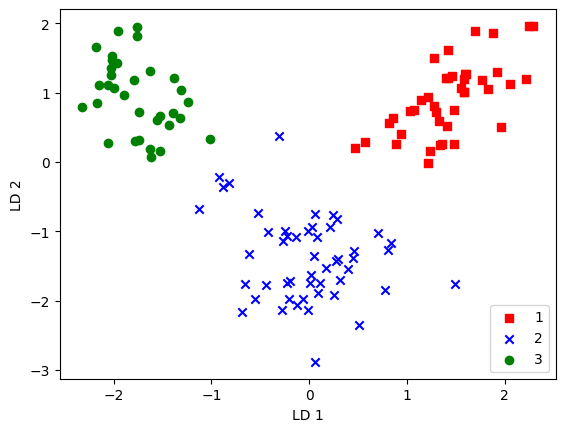

In [11]:
import matplotlib.pyplot as plt

X_train_lda = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1), c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.show()

# LDA via SciKitLearn

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)

X_train_lda = lda.fit_transform(X_train_std, y_train)

## Run Logistic Regression Classifier 

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8,c=colors[idx],marker=markers[idx],label=cl,edgecolor='black')

C:\Users\orul_\AppData\Local\Temp\ipykernel_8012\2296859498.py:20: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8,c=colors[idx],marker=markers[idx],label=cl,edgecolor='black')


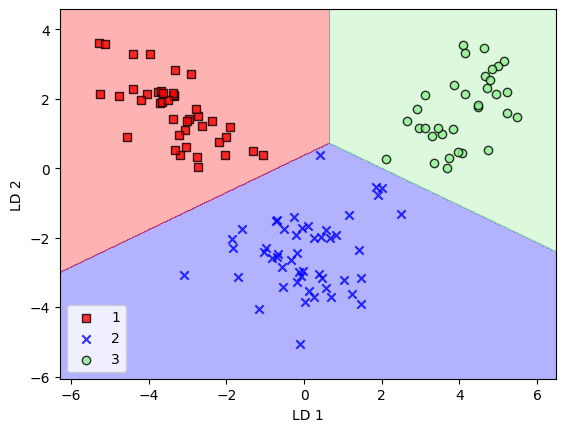

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()